In [1]:
import pathlib
import numpy as np
import pandas as pd
from scipy import sparse
import time
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from bayes_opt import BayesianOptimization
import loggingScoring as ls
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

### Initiating Logging

In [2]:
log = ls.get_logfile('6.log')
log.info('Support Vector Machine')

### Load Data

In [3]:
datapath = pathlib.Path('..') / 'Data'
data_loader = np.load(datapath / 'PreprocessedData.npz')
X_train = sparse.csr_matrix((data_loader['X_train_data'],
                             data_loader['X_train_indices'],
                             data_loader['X_train_indptr']),
                            shape = data_loader['X_train_shape'])
y_train = data_loader['y_train']
X_test = sparse.csr_matrix((data_loader['X_test_data'],
                            data_loader['X_test_indices'],
                            data_loader['X_test_indptr']),
                           shape = data_loader['X_test_shape'])
y_test = data_loader['y_test']

### Model

In [4]:
default_params = SVC().get_params()
print('Default Parameters of Support Vector Classifier :\n{}'.format(default_params))

Default Parameters of Support Vector Classifier :
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Fit time: 236.314 s / Predict time: 9.751 s ---- Precision: 0.959 / Recall: 0.96 / Accuracy: 0.961

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.96      0.96      3187
        Fake       0.96      0.96      0.96      2936

    accuracy                           0.96      6123
   macro avg       0.96      0.96      0.96      6123
weighted avg       0.96      0.96      0.96      6123

ROC AUC Score : 0.961078149567085


Confusion Matrix :



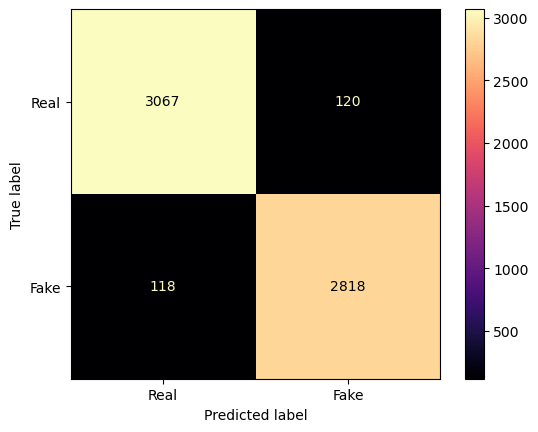

In [5]:
svc = SVC(random_state = 76)

start = time.time()
svc_model = svc.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = svc_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)

In [6]:
new_params = svc_model.get_params()
del new_params['random_state'], default_params['random_state']
# since we are manually setting random_state, removing that from comparison
if (default_params == new_params):
    print('No change observed in the Default Support Vector Classifier',\
                                    'parameters after fitting the data.')
else:
    print('Default Support Vector Classifier changed following parameters after fitting :')
    for key, value in default_params.items():
        if(value != new_params[key]):
            print('{} : {}'.format(key, new_params[key]))

No change observed in the Default Support Vector Classifier parameters after fitting the data.


Performance of the Default SVM Classifier has been amazing - best we have seen so far on this dataset, including other hyperparameter tuned classifiers. Let's see if we can achieve an even higher accuracy.

### Hyperparameter Tuning
I will use Bayesian Optimization again, but approach would be a little bit different - since, based on what kernel we choose for SVM, there can be quiet a few possibilities for hyperparameter combinations.

Since, default SVM classifier performed very well - I want to do an elaborate search of the parameter space. I will try 4 different kernels - linear, poly, rbf (default), and sigmoid. Default classifier score came with rbf kernel, so chances are that will be the best one - but, I want to give the others a try as well. I might even do a second level search if needed. Other than the kernel, the other 2 most important parameters are:
1) C is a regularization parameter (must be positive) - the value of C is inversely proportional to the strength of regularization applied, and directly proportional to the squared l2 penalty :

    - For a small value of C - regularization is high, but penalty for misclassification is low. So, a Decision Boundary with large margin is chosen, and as a result a greater number of misclassification is allowed.
    - For a large value of C - regularization is low, but penalty for misclassification is high - the further away from the decision boundary the wrongly classified sample is, higher the penalty. This results in a decision boundary with smaller margin.
2) gamma is a kernel coefficient mostly used with non-linear kernels, which "controls the distance of the influence of a single training point. Low values of gamma indicate a large similarity radius which results in more points being grouped together. For high values of gamma, the points need to be very close to each other in order to be considered in the same group (or class). Therefore, models with very large gamma values tend to overfit" (from this excellent [article](https://towardsdatascience.com/svm-hyperparameters-explained-with-visualizations-143e48cb701b)). Allowed values are 'scale', 'auto', or non-negative float. 'scale' indicates gamma value given by (1 / (n_features * X.var())), whereas 'auto' indicates gamma value given by (1 / n_features) - which for our training dataset, roughly translates into :
$$
gamma =
\begin{cases}
1/(35003 * 4.89e^-5) & \quad \text{when gamma = scale}\\
1/35003 & \quad \text{when gamma = auto}
\end{cases}
$$
$$
\approx
\begin{cases}
0.5845 & \quad \text{when gamma = scale}\\
2.8569e^-5 & \quad \text{when gamma = auto}
\end{cases}
$$
For gamma, I will use upto 0.00003 values as auto, and values between 0.56 and 0.6 as scale - other values will be used as is(float).

In [7]:
del default_params['cache_size'] # will be helpful in a comparison in the classifier_crossval_function
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 76)
kernel = 'rbf' # default kernel
curr_count, total_count = 0, 0 # to show progress

def classifier_crossval_function(C, # this regularization parameter will be supplied for all kernels, default 1
                                 coef0 = 0, # only significant in ‘poly’ and ‘sigmoid’
                                 degree = 3, # degree of the polynomial kernel function (‘poly’)
                                 gamma = 'scale', # kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
                                 tol = 1e-3 # tolerance for stopping criterion
                                ):
    '''
        This is the function the optimizer will call.
        The inputs for this function will be provided by the optimizer,
        the inputs are basically the parameters within the range that we have provided.
        The inputs can be (and mostly are) floats, if classifier requires
        discrete (int) values - they need to be adjusted as such.
        The function should be able to modify the inputs as per the requirements of the classifier,
        and then the classifer instance is instantiated with these provided parameters.
        Which parameters are set is determined by kernel, others are left to default values.
        And then the classifier is cross validated on training dataset.
        The return of the function is the mean score of the cross validation on training set -
        the Bayesian Optimizer will basically try to maximize this mean score.
        Not all the input arguments (except for C, tol) of the function will be provided for each kernel,
        hence svm default values are used as default values for the function just to be safe -
        since I'm already setting classifier hyperparameters as needed (by kernel).
    '''

    log.info(f'Raw Parameters : {kernel = }, {C = }, {coef0 = }, {degree = }, {gamma = }, {tol = }.')
    global curr_count
    curr_count += 1
    start = time.time()
    
    # modifying the hyperparameters to what SVM needs
    # gamma
    if (gamma != 'scale'): # not default
        if (gamma <= 0.00003):
            gamma = 'auto'
        elif ((gamma > 0.56) & (gamma < 0.6)):
            gamma = 'scale'
    # degree
    if (degree != 3): # not default
        degree = round(degree) # possible float to int

    log.info(f'Parameters To Be Used : {kernel = }, {C = }, {coef0 = }, {degree = }, {gamma = }, {tol = }.')
    
    if (kernel == 'linear'):
        svc_cv = SVC(kernel = kernel,
                     C = C,
                     tol = tol,
                     cache_size = 1000,
                     random_state = 76)
    elif (kernel == 'poly'):
        svc_cv = SVC(kernel = kernel,
                     C = C,
                     coef0 = coef0,
                     degree = degree,
                     gamma = gamma,
                     tol = tol,
                     cache_size = 1000,
                     random_state = 76)
    elif (kernel == 'rbf'):
        svc_cv = SVC(kernel = kernel,
                     C = C,
                     gamma = gamma,
                     tol = tol,
                     cache_size = 1000,
                     random_state = 76)
    elif (kernel == 'sigmoid'):
        svc_cv = SVC(kernel = kernel,
                     C = C,
                     coef0 = coef0,
                     tol = tol,
                     cache_size = 1000,
                     random_state = 76)
    else:
        log.error('Undefined Kernel !!!')

    curr_params = svc_cv.get_params()
    del curr_params['random_state'], curr_params['cache_size']
    if (default_params != curr_params):
        log.info('Changed Hyperparameters : ')
        for key, value in default_params.items():
            if(value != curr_params[key]):
                log.info('{} : {}'.format(key, curr_params[key]))

    scores = cross_val_score(estimator = svc_cv,
                             X = X_train,
                             y = y_train,
                             scoring = 'accuracy',
                             cv = skf,
                             verbose = 0)

    
    mean_score = round(scores.mean(), 5)
    end = time.time()
    time_taken = round((end - start), 3)
    
    log.info(f'({curr_count}/{total_count}) Time Taken : {time_taken} s. Score : {mean_score}.')
    return mean_score

In [8]:
# dictionary with param limits and optimizer (added later) for each kernel
dict_kernel_paramslim_optimizer_map = {
    'linear' : {
        'params_lim' : {
            'C' : (1e-3, 1e3),
            'tol' : (1e-4, 2)
        }
    },
    'poly' : {
        'params_lim' : {
            'C' : (1e-3, 1e3),
            'coef0' : (-20, 20),
            'degree' : (1, 5),
            'gamma' : (0, 15),
            'tol' : (1e-4, 2)
        }
    },
    'rbf' : {
        'params_lim' : {
            'C' : (1e-3, 1e3),
            'gamma' : (0, 15),
            'tol' : (1e-4, 2)
        }
    },
    'sigmoid' : {
        'params_lim' : {
            'C' : (1e-3, 1e3),
            'coef0' : (-20, 20),
            'tol' : (1e-4, 2)
        }
    }
}

for kernel in dict_kernel_paramslim_optimizer_map.keys():
    dict_kernel_paramslim_optimizer_map[kernel]['optimizer'] =\
                                    BayesianOptimization(f = classifier_crossval_function,
                                                         pbounds = dict_kernel_paramslim_optimizer_map[kernel]['params_lim'],
                                                         random_state = 76,
                                                         verbose = 1)
#structure of the dictionary
pprint(dict_kernel_paramslim_optimizer_map)

{'linear': {'optimizer': <bayes_opt.bayesian_optimization.BayesianOptimization object at 0x7f994a60d210>,
            'params_lim': {'C': (0.001, 1000.0), 'tol': (0.0001, 2)}},
 'poly': {'optimizer': <bayes_opt.bayesian_optimization.BayesianOptimization object at 0x7f994a60e560>,
          'params_lim': {'C': (0.001, 1000.0),
                         'coef0': (-20, 20),
                         'degree': (1, 5),
                         'gamma': (0, 15),
                         'tol': (0.0001, 2)}},
 'rbf': {'optimizer': <bayes_opt.bayesian_optimization.BayesianOptimization object at 0x7f994a60f010>,
         'params_lim': {'C': (0.001, 1000.0),
                        'gamma': (0, 15),
                        'tol': (0.0001, 2)}},
 'sigmoid': {'optimizer': <bayes_opt.bayesian_optimization.BayesianOptimization object at 0x7f9949a73d60>,
             'params_lim': {'C': (0.001, 1000.0),
                            'coef0': (-20, 20),
                            'tol': (0.0001, 2)}}}


In [9]:
num_initialization_rounds, num_iterations = 25, 100 # number of optimizer runs
for kernel in dict_kernel_paramslim_optimizer_map.keys():
    print(f'Optimizing for {kernel} Kernel.')
    #same kernel value will be used in the crossval function as well
    curr_count, total_count = 0, (num_initialization_rounds + num_iterations)
    curr_optimizer = dict_kernel_paramslim_optimizer_map[kernel]['optimizer']
    curr_optimizer.maximize(init_points = num_initialization_rounds,
                            n_iter = num_iterations)
    print(f'Best score for {kernel} kernel : {curr_optimizer.max}')
    print('_' * 125)

Optimizing for linear Kernel.
|   iter    |  target   |     C     |    tol    |
-------------------------------------------------
| 2         | 0.944     | 334.8     | 0.3875    |
| 3         | 0.9445    | 110.3     | 1.925     |
| 5         | 0.9467    | 79.51     | 1.522     |
| 21        | 0.9471    | 80.72     | 1.082     |
| 22        | 0.9477    | 37.83     | 1.366     |
| 29        | 0.9493    | 27.46     | 0.05649   |
| 31        | 0.9518    | 7.137     | 0.2012    |
| 45        | 0.9524    | 5.425     | 0.497     |
| 59        | 0.9525    | 5.985     | 0.05274   |
| 69        | 0.9533    | 4.527     | 0.0974    |
| 100       | 0.9539    | 3.523     | 0.2605    |
Best score for linear kernel : {'target': 0.95391, 'params': {'C': 3.5230548019501016, 'tol': 0.2605186547458603}}
_____________________________________________________________________________________________________________________________
Optimizing for poly Kernel.
|   iter    |  target   |     C     |   coef0   |  

Best results for each kernel are pretty good - rbf and sigmoid kernels performed best. Let me take a closer look at their best scores' param space.

In [10]:
# storing the optimization results
list_all_parameters = ['C', 'coef0', 'degree', 'gamma', 'tol']
flattened_res_list = []
for kernel, dict_params_and_optimizer in dict_kernel_paramslim_optimizer_map.items():
    dict_params_lim, optimizer = dict_params_and_optimizer['params_lim'], dict_params_and_optimizer['optimizer']
    curr_kernel_used_params = dict_params_lim.keys()
    for res in optimizer.res:
        flattened_dict = {}
        flattened_dict['kernel'] = kernel
        for param in list_all_parameters:
            if (param in curr_kernel_used_params):
                flattened_dict[param] = res['params'][param]
            else:
                flattened_dict[param] = np.nan
        flattened_dict['mean_test_score'] = res['target']
        flattened_res_list.append(flattened_dict)
df_results_bo = pd.DataFrame(flattened_res_list).sort_values('mean_test_score', ascending = False)
df_results_bo.to_csv(datapath / 'HPTuningResults' / 'SVM_Bayesian-results.csv', index = False)
df_results_bo.head()

,kernel,C,coef0,degree,gamma,tol,mean_test_score
330,rbf,166.518279,NaN,NaN,0.737338,0.060661,0.96123
276,rbf,196.108875,NaN,NaN,0.709084,0.629271,0.96103
437,sigmoid,704.408077,-3.928123,NaN,NaN,0.000100,0.96060
431,sigmoid,681.418948,-2.542300,NaN,NaN,0.418552,0.96046
493,sigmoid,255.373879,-3.099925,NaN,NaN,0.000100,0.96043


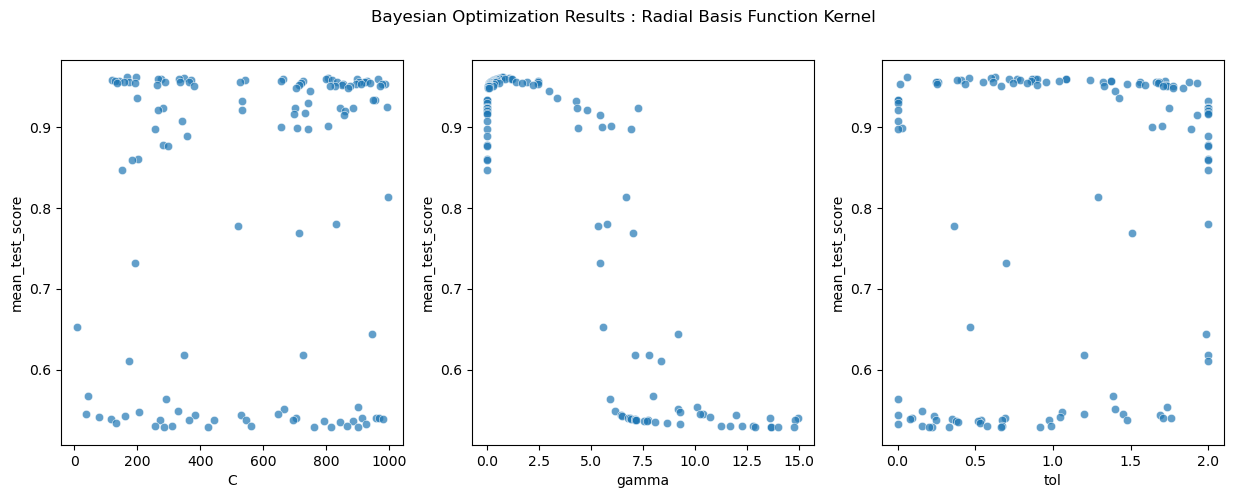

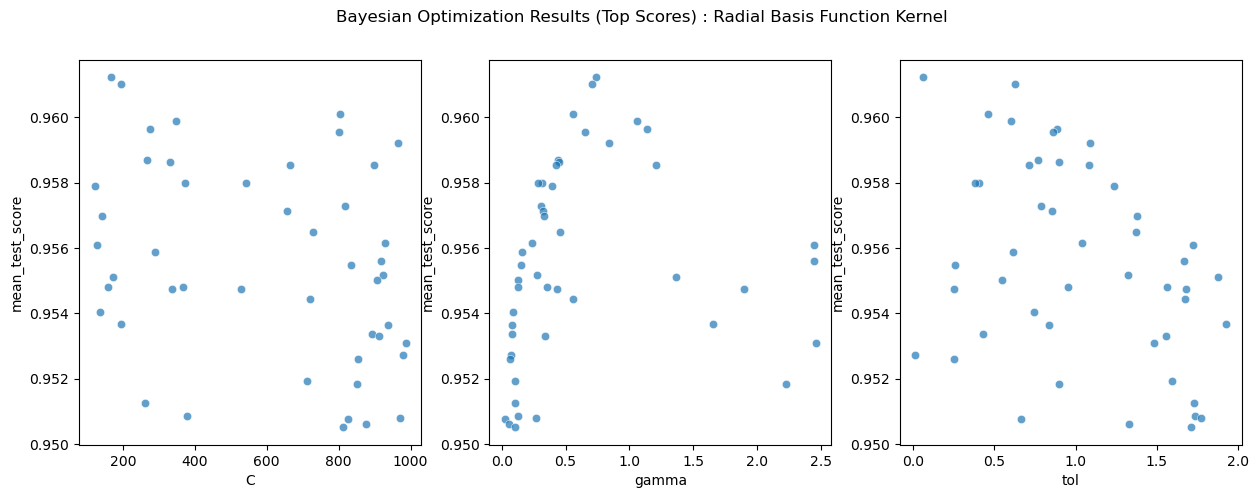

In [11]:
# visualizing the parameter space
# rbf - overall plot, and then looking at the high scoring parameter combinations
df_svm_rbf_plot = df_results_bo[df_results_bo.kernel == 'rbf']
df_svm_rbf_plot_top = df_results_bo[(df_results_bo.mean_test_score > 0.95) & (df_results_bo.kernel == 'rbf')]

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
sns.scatterplot(data = df_svm_rbf_plot, x = 'C', y = 'mean_test_score', alpha = 0.7, ax = axes[0])
sns.scatterplot(data = df_svm_rbf_plot, x = 'gamma', y = 'mean_test_score', alpha = 0.7, ax = axes[1])
sns.scatterplot(data = df_svm_rbf_plot, x = 'tol', y = 'mean_test_score', alpha = 0.7, ax = axes[2])
fig.suptitle('Bayesian Optimization Results : Radial Basis Function Kernel')
plt.show()
plt.close()
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
sns.scatterplot(data = df_svm_rbf_plot_top, x = 'C', y = 'mean_test_score', alpha = 0.7, ax = axes[0])
sns.scatterplot(data = df_svm_rbf_plot_top, x = 'gamma', y = 'mean_test_score', alpha = 0.7, ax = axes[1])
sns.scatterplot(data = df_svm_rbf_plot_top, x = 'tol', y = 'mean_test_score', alpha = 0.7, ax = axes[2])
fig.suptitle('Bayesian Optimization Results (Top Scores) : Radial Basis Function Kernel')
plt.show()
plt.close()

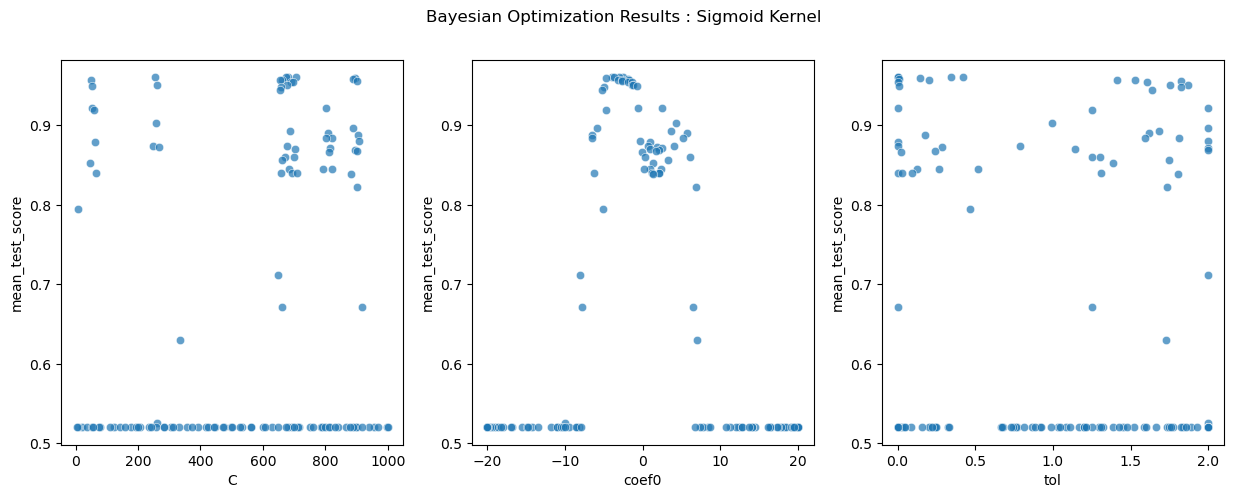

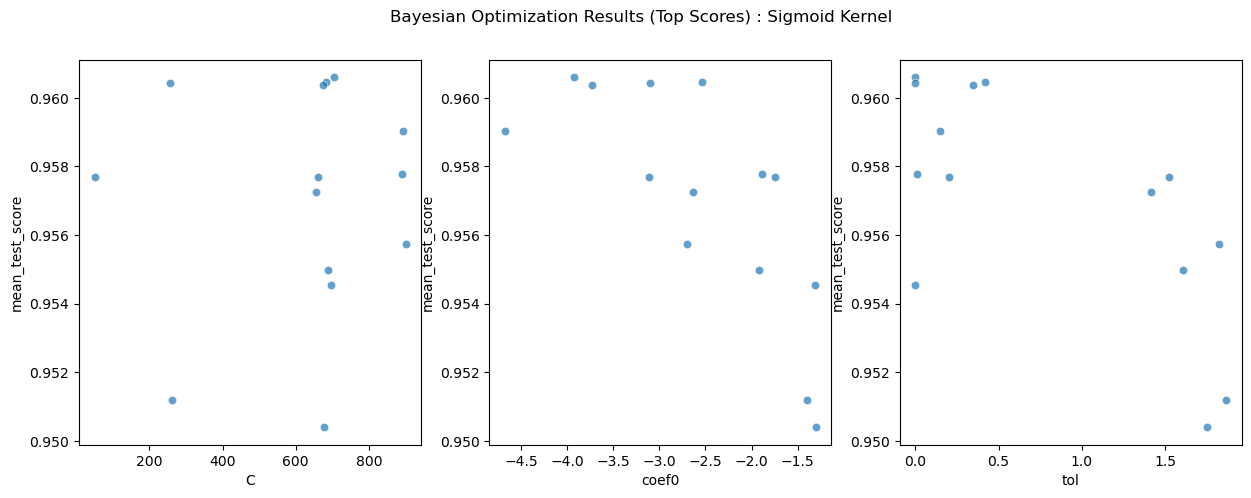

In [12]:
# sigmoid - overall plot, and then looking at the high scoring parameter combinations
df_svm_sigmoid_plot = df_results_bo[df_results_bo.kernel == 'sigmoid']
df_svm_sigmoid_plot_top = df_results_bo[(df_results_bo.mean_test_score > 0.95) & (df_results_bo.kernel == 'sigmoid')]

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
sns.scatterplot(data = df_svm_sigmoid_plot, x = 'C', y = 'mean_test_score', alpha = 0.7, ax = axes[0])
sns.scatterplot(data = df_svm_sigmoid_plot, x = 'coef0', y = 'mean_test_score', alpha = 0.7, ax = axes[1])
sns.scatterplot(data = df_svm_sigmoid_plot, x = 'tol', y = 'mean_test_score', alpha = 0.7, ax = axes[2])
fig.suptitle('Bayesian Optimization Results : Sigmoid Kernel')
plt.show()
plt.close()
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
sns.scatterplot(data = df_svm_sigmoid_plot_top, x = 'C', y = 'mean_test_score', alpha = 0.7, ax = axes[0])
sns.scatterplot(data = df_svm_sigmoid_plot_top, x = 'coef0', y = 'mean_test_score', alpha = 0.7, ax = axes[1])
sns.scatterplot(data = df_svm_sigmoid_plot_top, x = 'tol', y = 'mean_test_score', alpha = 0.7, ax = axes[2])
fig.suptitle('Bayesian Optimization Results (Top Scores) : Sigmoid Kernel')
plt.show()
plt.close()

Based on what can be seen above, I want to do another round of optimization for rbf and sigmoid kernels - with smaller boundaries for the parameters, hoping for an even better score.

In [13]:
num_initialization_rounds, num_iterations = 15, 25 # number of optimizer runs

dict_kernel_paramslim_optimizer_map['rbf']['new_params_lim'] = {
    'C' : (100, 400),
    'gamma' : (0.5, 1.5),
    'tol' : (1e-5, 0.6)
}
dict_kernel_paramslim_optimizer_map['sigmoid']['new_params_lim'] = {
    'C' : (200, 700),
    'coef0' : (-4, -2.5),
    'tol' : (1e-5, 0.5)
}

for kernel in ['rbf', 'sigmoid']:
    print(f'Re-Optimizing with New Limits for {kernel} Kernel.')
    curr_count, total_count = 0, (num_initialization_rounds + num_iterations)
    curr_optimizer = dict_kernel_paramslim_optimizer_map[kernel]['optimizer']
    curr_optimizer.set_bounds(new_bounds = dict_kernel_paramslim_optimizer_map[kernel]['new_params_lim'])
    curr_optimizer.maximize(init_points = num_initialization_rounds,
                            n_iter = num_iterations)
    print(f'New Best score for {kernel} kernel : {curr_optimizer.max}')
    print('_' * 125)

Re-Optimizing with New Limits for rbf Kernel.
|   iter    |  target   |     C     |   gamma   |    tol    |
-------------------------------------------------------------
| 140       | 0.9614    | 379.6     | 0.9611    | 0.02575   |
| 158       | 0.9614    | 285.8     | 0.8546    | 0.0151    |
New Best score for rbf kernel : {'target': 0.96141, 'params': {'C': 285.8399400122811, 'gamma': 0.8545885001060639, 'tol': 0.01509903950227895}}
_____________________________________________________________________________________________________________________________
Re-Optimizing with New Limits for sigmoid Kernel.
|   iter    |  target   |     C     |   coef0   |    tol    |
-------------------------------------------------------------
| 127       | 0.961     | 642.8     | -2.722    | 0.0653    |
| 139       | 0.9611    | 553.6     | -3.898    | 0.2488    |
New Best score for sigmoid kernel : {'target': 0.96106, 'params': {'C': 553.6121371978816, 'coef0': -3.8981572729795486, 'tol': 0.2487628

In [16]:
# storing the optimization results - once more
list_all_parameters = ['C', 'coef0', 'degree', 'gamma', 'tol']
flattened_res_list = []
for kernel, dict_params_and_optimizer in dict_kernel_paramslim_optimizer_map.items():
    dict_params_lim, optimizer = dict_params_and_optimizer['params_lim'], dict_params_and_optimizer['optimizer']
    curr_kernel_used_params = dict_params_lim.keys()
    for res in optimizer.res:
        flattened_dict = {}
        flattened_dict['kernel'] = kernel
        for param in list_all_parameters:
            if (param in curr_kernel_used_params):
                flattened_dict[param] = res['params'][param]
            else:
                flattened_dict[param] = np.nan
        flattened_dict['mean_test_score'] = res['target']
        flattened_res_list.append(flattened_dict)
df_results_bo = pd.DataFrame(flattened_res_list).sort_values('mean_test_score', ascending = False)
df_results_bo.to_csv(datapath / 'HPTuningResults' / 'SVM_Bayesian-results_2.csv', index = False)
df_results_bo.head()

,kernel,C,coef0,degree,gamma,tol,mean_test_score
407,rbf,285.839940,NaN,NaN,0.854589,0.015099,0.96141
389,rbf,379.550647,NaN,NaN,0.961091,0.025746,0.96138
380,rbf,126.717710,NaN,NaN,0.780727,0.091258,0.96123
330,rbf,166.518279,NaN,NaN,0.737338,0.060661,0.96123
553,sigmoid,553.612137,-3.898157,NaN,NaN,0.248763,0.96106


### Best Model

Fit time: 233.646 s / Predict time: 12.761 s ---- Precision: 0.963 / Recall: 0.958 / Accuracy: 0.962

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.97      0.96      3187
        Fake       0.96      0.96      0.96      2936

    accuracy                           0.96      6123
   macro avg       0.96      0.96      0.96      6123
weighted avg       0.96      0.96      0.96      6123

ROC AUC Score : 0.9619389994605128


Confusion Matrix :



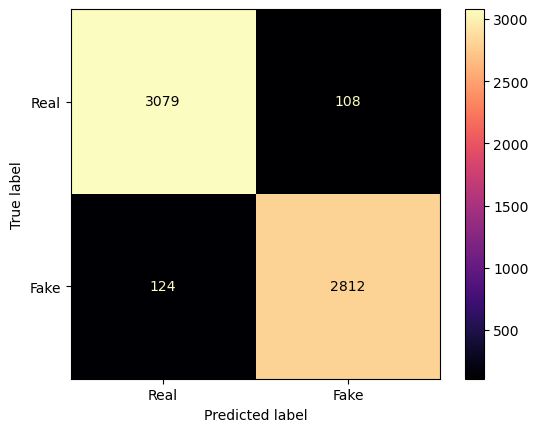

In [14]:
svc_best = SVC(kernel = 'rbf', C = 285.84, gamma = 0.8546, tol = 0.015, cache_size=1000, random_state=76)

start = time.time()
svc_model_best = svc_best.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_best = svc_model_best.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred_best, fit_time, pred_time)